# Reference model final

In [1]:
from data import *
from transfer_learning import *
from test_functions import *
from layers import *
from utils import *
from loss import *
from metric import *
from results import *
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

Using TensorFlow backend.


In [2]:
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = \
    read_df_with_transfer_learning_subset_fewerDomainFeatures(['age','Temperature','Precipitation3Days'])

In [3]:
print(df_domain_train.shape)
print(df_domain_test.shape)

(4251, 3)
(373, 3)


In [4]:
print('TRAIN:')
print('age:' + str(df_domain_train.loc[:,'age'].mean()))
print('rain:' + str(df_domain_train.loc[:,'Precipitation3Days'].mean()))
print('Tª:' + str(df_domain_train.loc[:,'Temperature'].mean()))
    
print('TEST:')
print('age:' + str(df_domain_test.loc[:,'age'].mean()))
print('rain:' + str(df_domain_test.loc[:,'Precipitation3Days'].mean()))
print('Tª:' + str(df_domain_test.loc[:,'Temperature'].mean()))

TRAIN:
age:9.131498470948012
rain:0.4424182545283462
Tª:69.01096212655845
TEST:
age:9.091152815013405
rain:0.4129758713136729
Tª:69.06434316353888


### Get numpy transfer_learning objects

In [5]:
data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

# Auto-encoder OTU latent

In [6]:
from train_2 import *

### Get microbioma train data and numpy train objects

In [7]:
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = \
    read_df_with_transfer_learning_subset_fewerDomainFeatures(['age','Temperature','Precipitation3Days'])

In [8]:
data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

In [9]:
data_microbioma_train.shape

(4251, 717)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 10 |
| Bioma Autoencoder | b -> 512 -> 256 -> 10 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>99</b></p>

<b>loss</b>: 0.1631 (min: 0.1631, max: 0.1631)

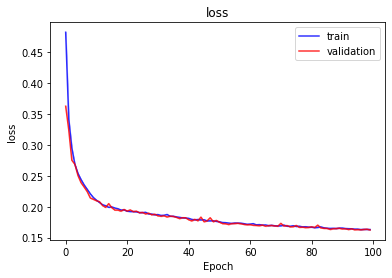

<b>bioma_mse</b>: 0.0000 (min: 0.0000, max: 0.0000)

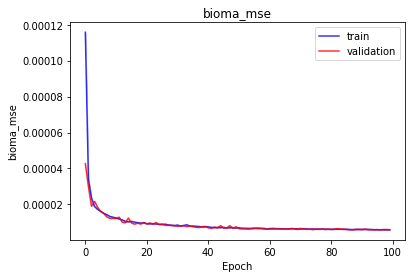

<b>bioma_mae</b>: 0.0004 (min: 0.0004, max: 0.0004)

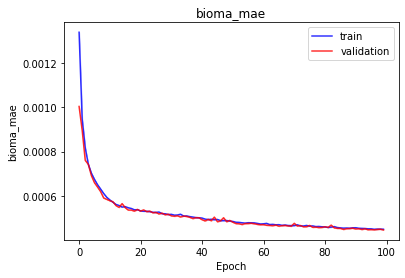

<b>bioma_mape</b>: 4060.0955 (min: 4060.0955, max: 4060.0955)

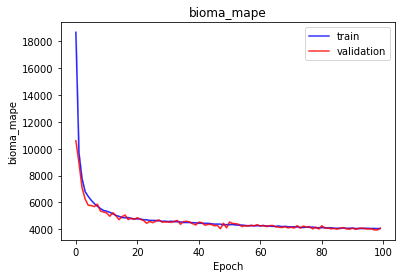

<b>bioma_BrayCurtis</b>: 0.1631 (min: 0.1631, max: 0.1631)

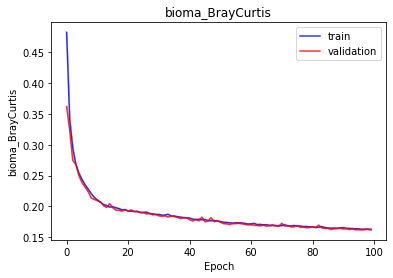

<b>bioma_pearson_corr</b>: 0.9495 (min: 0.9495, max: 0.9495)

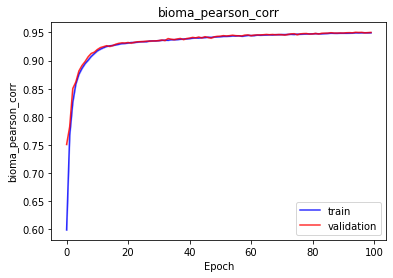

<b>bioma_jensen_shannon_divergence</b>: 0.2646 (min: 0.2646, max: 0.2646)

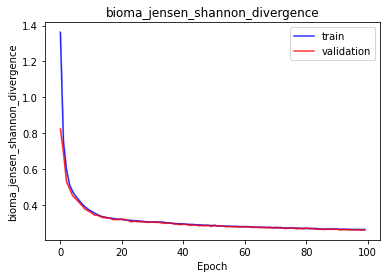

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.16313993290743248 | 0.16313993290743248 | 0.16313993290743248 |
| bioma_mse | 5.9371814131736755e-06 | 5.9371814131736755e-06 | 5.9371814131736755e-06 |
| bioma_mae | 0.00044932746095582843 | 0.00044932746095582843 | 0.00044932746095582843 |
| bioma_mape | 4060.095458984375 | 4060.095458984375 | 4060.095458984375 |
| bioma_BrayCurtis | 0.1631399542093277 | 0.1631399542093277 | 0.1631399542093277 |
| bioma_pearson_corr | 0.9494578838348389 | 0.9494578838348389 | 0.9494578838348389 |
| bioma_jensen_shannon_divergence | 0.264644593000412 | 0.264644593000412 | 0.264644593000412 |


*************

In [10]:
# Train the selected model (the best one from those with the smallest latent space (10)): no.351
experiment_metrics, models, results = perform_experiment_2(cv_folds=0, 
                        epochs=100, 
                        batch_size=64, 
                        learning_rate=0.001, 
                        optimizer=optimizers.Adam,
                        learning_rate_scheduler=None,
                        input_transform=Percentage,
                        output_transform=tf.keras.layers.Softmax,
                        reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None), 
                        latent_space=10, 
                        layers=[512,256],
                        activation='tanh', 
                        activation_latent='tanh', 
                        data_microbioma_train=data_microbioma_train,
                        data_domain_train=None,
                        show_results=True, 
                        device='/CPU:0')

### To get encoders and decoders to use in domain->latent model

In [11]:
model, encoder, _ ,decoder = models[0]

In [12]:
df_domain_train.shape

(4251, 3)

### To predict latent space for samples in domain->latent model

In [13]:
latent_train = encoder.predict(data_microbioma_train)
latent_test = encoder.predict(data_microbioma_test)

### To build model to predict latent space 

In [14]:
def model_fn_latent():
    in_layer = layers.Input(shape=(3,))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(64, activation='tanh')(net)
    net = layers.Dense(32, activation='tanh')(net)
    net = layers.Dense(16, activation='tanh')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation=None)(net) # 'tanh already'
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [15]:
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                            latent_train,
                            latent_train,
                            data_domain_train,
                            data_domain_train,
                            epochs=100,
                            batch_size=16,
                            verbose=-1)

In [16]:
print_results_noEnsemble(result_latent)

<p>Best iteration: <b>74</b></p>

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.060972585827830786 | 0.05935779990336105 | 0.08141214553975717 |
| domain_mean_squared_error | 0.06097258999943733 | 0.05935780704021454 | 0.081412173807621 |


In [17]:
# Test only Dense(domain->latent)
predictions = test_model_tl_latent(model_latent, latent_test, data_domain_test)
#save_predictions(predictions, 'experiment_testSet_domain-latent_AE_OTUlatent_3var.txt)

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| mse | 0.059301476925611496 | 3.3864054671539634e-08 | 1.0656218528747559 |


### Domain -> latent -> microbiome. Test set

In [18]:
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, data_microbioma_test, data_domain_test)

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.4181441366672516 | 0.4181441366672516 | 0.4181441366672516 |
| pearson_corr | 0.7348228096961975 | 0.7348228096961975 | 0.7348228096961975 |
| jensen_shannon_divergence | 0.8599598407745361 | 0.8599598407745361 | 0.8599598407745361 |


### Save model

In [19]:
encoder.save('encoder_biome.h5')
decoder.save('decoder.h5')
model_latent.save('encoder_domain_model_latent.h5')

NotImplementedError: Layers with arguments in `__init__` must override `get_config`.

In [ ]:
new_decoder = tf.keras.models.load_model('decoder.h5')

In [ ]:
new_model_latent = tf.keras.models.load_model('model_latent.h5')

In [ ]:
predictions = test_model_tl_noEnsemble(new_model_latent, new_decoder, Percentage, tf.keras.layers.Softmax, data_microbioma_test, data_domain_test)